## ***Import the Dependencies***

In [1]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.resnet import ResNet50
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## ***`Loading and Preprocessing the Data`***

In [2]:
# Load the data from Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Unzip the data
!unzip '/content/drive/MyDrive/task/Coffee Leaves.zip' -d '/content/drive/MyDrive/task'
# Data is already Unzipped

Archive:  /content/drive/MyDrive/task/Coffee Leaves.zip
replace /content/drive/MyDrive/task/Coffee Leaves/dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
# Read the Csv File into the data  frame
data_frame = pd.read_csv('/content/drive/MyDrive/task/Coffee Leaves/dataset.csv')

# Convert the Values in the 'id' columns of the csv file to string. This required by the ImageDataGenerator
data_frame['id'] = data_frame['id'].apply(lambda x: str(x) + '.jpg')

In [5]:
data_frame.head()

,id,predominant_stress,miner,rust,phoma,cercospora,severity
0,1.jpg,0,0,0,0,0,0
1,2.jpg,0,0,0,0,0,0
2,3.jpg,0,0,0,0,0,0
3,4.jpg,0,0,0,0,0,0
4,5.jpg,0,0,0,0,0,0


In [6]:
# The ImageDataGenerator will create data generators for training, validation and test sets of data.
# However the output of those generators will be tupels (x, y).
# we need to split the targets (y) to feed them to the two branches of the model.
# We will do this using the following function.

def split_outputs(generator1, generator2):
    while True:
        x1 = generator1.next()
        x2 = generator2.next()
        yield x1[0], [x1[1], x2[1]] 

# ***Define The Hyperparameters***

In [7]:
m = data_frame.shape[0]                                       # Number of exampels in the dataset
sr1 = m * 8 // 10                                             # split_ratio 1
sr2 = m * 9 // 10                                             # split_ratio 2 
training_exampels = sr1                                       # Number of Training exampels
validation_exampels = sr2 - sr1                               # Number of Validation exampels
testing_exampels = m - sr2                                    # Number of Testing exampels is
batch_size = 32                                               # Batch Size
input_shape = (224, 224, 3)                                   # Shape of the Input Image

epochs = 30                                                   # Number of Epochs
steps_per_epoch = training_exampels // batch_size             # Steps per Epoch
validation_steps = validation_exampels // batch_size          # Validation Steps
testing_steps = testing_exampels / batch_size                 # Testing Steps

In [8]:
# we will split the data into three subsets, training, validation and test.
# Splitting of Data will be [80 % - 10 % - 10 %]

print('The Whole Dataset Consists of :-    ', m, 'Exampels')
print('Number of Training exampels is :-   ', training_exampels, 'Exampels')
print('Number of Validation exampels is :- ', validation_exampels, 'Exampels')
print('Number of Testing exampels is :-    ', testing_exampels, 'Exampels')

The Whole Dataset Consists of :-     1747 Exampels
Number of Training exampels is :-    1397 Exampels
Number of Validation exampels is :-  175 Exampels
Number of Testing exampels is :-     175 Exampels


In [9]:
# Loading the training set.
# The ImageDataGenerator is used for data Augmentation.
# Augmentaion Techniques used are rotaion and flipping (horizontal and vertical)

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator_regression = train_datagen.flow_from_dataframe(dataframe = data_frame[:sr1], directory = '/content/drive/MyDrive/task/Coffee Leaves/images/',
                                                    x_col = 'id', y_col = ['predominant_stress','severity'], batch_size = batch_size, seed = 42, shuffle = False,
                                                    class_mode = 'raw', target_size = (224, 224))
train_generator_classification = train_datagen.flow_from_dataframe(dataframe = data_frame[:sr1], directory = '/content/drive/MyDrive/task/Coffee Leaves/images/',
                                                    x_col = 'id', y_col = ['miner', 'rust', 'phoma', 'cercospora'], batch_size = batch_size, seed = 42, shuffle = False,
                                                    class_mode = 'raw', target_size = (224, 224))


valid_generator_regression = test_datagen.flow_from_dataframe(dataframe = data_frame[sr1:sr2], directory = '/content/drive/MyDrive/task/Coffee Leaves/images/',
                                                    x_col = 'id', y_col = ['predominant_stress','severity'], batch_size = batch_size, seed = 42, shuffle = False,
                                                    class_mode = 'raw', target_size = (224, 224))
valid_generator_classification = test_datagen.flow_from_dataframe(dataframe = data_frame[sr1:sr2], directory = '/content/drive/MyDrive/task/Coffee Leaves/images/',
                                                    x_col = 'id', y_col = ['miner', 'rust', 'phoma', 'cercospora'], batch_size = batch_size, seed = 42, shuffle = False,
                                                    class_mode = 'raw', target_size = (224, 224))

test_generator_regression = test_datagen.flow_from_dataframe(dataframe = data_frame[sr2:], directory = '/content/drive/MyDrive/task/Coffee Leaves/images/',
                                                    x_col = 'id', y_col = ['predominant_stress','severity'], batch_size = batch_size, seed = 42, shuffle = True,
                                                    class_mode = 'raw', target_size = (224, 224))
test_generator_classification = test_datagen.flow_from_dataframe(dataframe = data_frame[sr2:], directory = '/content/drive/MyDrive/task/Coffee Leaves/images/',
                                                    x_col = 'id', y_col = ['miner', 'rust', 'phoma', 'cercospora'], batch_size = batch_size, seed = 42, shuffle = True,
                                                    class_mode = 'raw', target_size = (224, 224))

Found 1397 validated image filenames.
Found 1397 validated image filenames.
Found 175 validated image filenames.
Found 175 validated image filenames.
Found 175 validated image filenames.
Found 175 validated image filenames.


# ***Creating The Model***



In [10]:
x = next(split_outputs(train_generator_regression, train_generator_classification))
x[1]

[array([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [3, 2],
        [1, 3],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 2],
        [1, 1],
        [1, 2],
        [1, 1],
        [1, 1],
        [1, 3],
        [1, 1]]), array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
   

In [11]:
# We will use transfer learning and we will use Resnet50 as the base model.
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)

last_output = base_model.output

x = Flatten()(last_output)                      # We will feed this to the two branches of our Model.

# Because the accuary of the classification branch was not that good we will add two fully connected layers before the
# classification output and only one layer before the regression one.
x1 = Dense(1024, activation='relu')(x)
x1 = Dropout(0.2)(x1)
x1 = Dense(512, activation='relu')(x1)

x2 = Dense(1024, activation='relu')(x)
x2 = Dropout(0.2)(x2)
x2 = Dense(512, activation='relu')(x2)


94781440/94765736 [==============================] - 1s 0us/step


In [12]:
# Now We will Defing the Two branches.
# The First branch is for the Regression part of the Problem. I will Contain two neurons, one for predicting the predominant stress
# and the other one for predicting the Severity. 
# Relu is the activation function used in this branch, Rectified Linear Unit
out1 = Dense(2, activation='linear', name = 'regression_branch')(x1)

# The Second branch is for the Classification part of the Problem. I will Contain Four neurons, one for each of the stresses
# Sigmoid is the activation function used in this branch because this is a multi-label task.
out2 = Dense(4, activation='sigmoid', name = 'classification_branch')(x2)

In [13]:
# Creating the Model
model = Model(inputs=base_model.input, outputs=[out1, out2])

In [14]:
# Visualize The Model
plot_model(model, to_file='model.png', show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# Summarize The Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# ***Compiling The Model***

In [16]:
# Creating a ModelCheckoint callback for each branch of the model to save the best mode.
regression_checkpointer = ModelCheckpoint(monitor= 'val_regression_branch_loss',
                                              filepath='/content/drive/MyDrive/task/resnet_val_regression_branch_loss.model.hdf5',
                                              save_best_only=True)

classification_checkpointer = ModelCheckpoint(monitor= 'val_classification_branch_loss',
                                              filepath='/content/drive/MyDrive/task/resnet_val_classification_branch_loss.model.hdf5',
                                              save_best_only=True)

# Compile The Model
# We will use Stochastic Gradient Descent as our Optimizer.
# For the regression Branch we will use 'Mean Squared Error' as the loss function
# For the Classification Branch we will use 'Binary Cross Entropy'
model.compile(optimizer = 'adam', loss=['mse','binary_crossentropy'], metrics=['accuracy'])

# ***Training The Model***

In [17]:
history = model.fit_generator(split_outputs(train_generator_regression, train_generator_classification), validation_data=split_outputs(valid_generator_regression, valid_generator_classification),
                              callbacks=[regression_checkpointer, classification_checkpointer], epochs = epochs,
                              steps_per_epoch=steps_per_epoch, validation_steps = validation_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
43/43 [==============================] - 428s 9s/step - loss: 2142.8931 - regression_branch_loss: 2139.1169 - classification_branch_loss: 3.7758 - regression_branch_accuracy: 0.6044 - classification_branch_accuracy: 0.5949 - val_loss: 85.2826 - val_regression_branch_loss: 84.0818 - val_classification_branch_loss: 1.2008 - val_regression_branch_accuracy: 0.9312 - val_classification_branch_accuracy: 0.6438


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
43/43 [==============================] - 184s 4s/step - loss: 2.1963 - regression_branch_loss: 1.5676 - classification_branch_loss: 0.6288 - regression_branch_accuracy: 0.6519 - classification_branch_accuracy: 0.3343 - val_loss: 19.4930 - val_regression_branch_loss: 18.7047 - val_classification_branch_loss: 0.7883 - val_regression_branch_accuracy: 0.9312 - val_classification_branch_accuracy: 0.6438
Epoch 3/30
43/43 [==============================] - 183s 4s/step - loss: 2.1656 - regression_branch_loss: 1.5557 - classification_branch_loss: 0.6099 - regression_branch_accuracy: 0.6007 - classification_branch_accuracy: 0.4784 - val_loss: 5.3884 - val_regression_branch_loss: 4.7203 - val_classification_branch_loss: 0.6681 - val_regression_branch_accuracy: 0.9312 - val_classification_branch_accuracy: 0.0875
Epoch 4/30
43/43 [==============================] - 185s 4s/step - loss: 2.2281 - regression_branch_loss: 1.5392 - classification_branch_loss: 0.6889 - regression_branch_accura

In [18]:
path = '/content/drive/MyDrive/task/Coffee Leaves/images/'
img = load_img(path + str(150) + '.jpg', target_size=(224, 224, 3))
img = img_to_array(img) / 255.
img = np.expand_dims(img, axis = 0)
a = model.predict(img)
a


[array([[2.19237  , 1.2528931]], dtype=float32),
 array([[9.98406932e-02, 9.93565857e-01, 1.51066852e-04, 1.24009185e-01]],
       dtype=float32)]

In [19]:
# Plotting the Training and Validation Accuracies and Losses.
def plot_training_history(history, epochs):
    regression_branch_accuracy = history.history['regression_branch_accuracy']
    regression_branch_loss = history.history['regression_branch_loss']

    classification_branch_accuracy = history.history['classification_branch_accuracy']
    classification_branch_loss = history.history['classification_branch_loss']
    
    val_regression_branch_accuracy = history.history['val_regression_branch_accuracy']
    val_regression_branch_loss = history.history['val_regression_branch_loss']
    
    val_classification_branch_accuracy = history.history['val_classification_branch_accuracy']
    val_classification_branch_loss = history.history['val_classification_branch_loss']
    
    epochs = range(epochs)
 
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, regression_branch_accuracy, 'r', label='regression branch accuracy')
    plt.plot(epochs, classification_branch_accuracy, 'b', label='classification branch accuracy')
    plt.plot(epochs, val_classification_branch_accuracy, 'g', label='val classification branch accuracy')
    plt.plot(epochs, val_regression_branch_accuracy, 'y', label='val regression branch accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, regression_branch_loss, 'r', label='regression branch loss')
    plt.plot(epochs, classification_branch_loss, 'b', label='classification branch loss')
    plt.plot(epochs, val_classification_branch_loss, 'g', label='val classification branch loss')
    plt.plot(epochs, val_regression_branch_loss, 'y', label='val regression branch loss')
    plt.title('Training and validation Loss')
    plt.legend()
 
    plt.show()

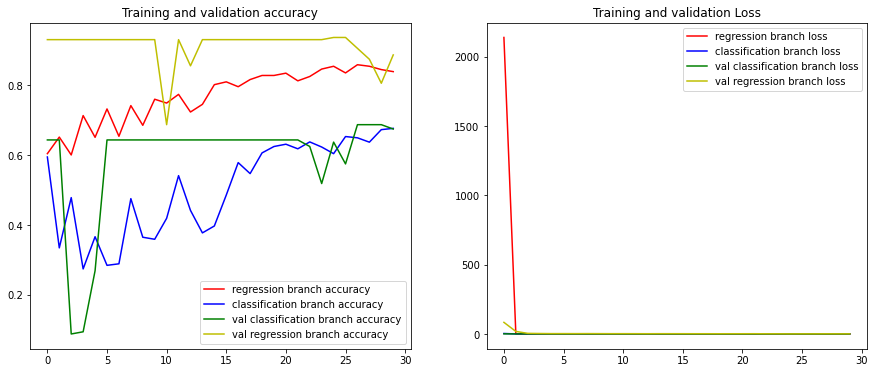

In [20]:
plot_training_history(history, epochs)

# ***Evaluate The Model***

In [21]:
def best_model(model1, model2, testing_steps):
  a = model1.evaluate_generator(split_outputs(test_generator_regression, test_generator_classification), testing_steps)
  b = model2.evaluate_generator(split_outputs(test_generator_regression, test_generator_classification), testing_steps)
  if a[-2] + a[-1] >= b[-2] + b[-1]:
    model1.save('/content/drive/MyDrive/task/best_Res_model.h5')
    print('The Best Model Accuracies are :-         ')
    print('Accuracy of the Regression Part is :-    ', a[-2] * 100)
    print('Accuracy of the Classification Part is :-', a[-1] * 100)
  else:
    model2.save('/content/drive/MyDrive/task/best_Res_model.h5')
    print('The Best Model Accuracies are :-         ')
    print('Accuracy of the Regression Part is :-    ', b[-2] * 100)
    print('Accuracy of the Classification Part is :-', b[-1] * 100)

In [22]:
# Get the Best Model
model1 = load_model('/content/drive/MyDrive/task/resnet_val_regression_branch_loss.model.hdf5')
model2 = load_model('/content/drive/MyDrive/task/resnet_val_classification_branch_loss.model.hdf5')
best_model(model1, model2, testing_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


The Best Model Accuracies are :-         
Accuracy of the Regression Part is :-     93.71428489685059
Accuracy of the Classification Part is :- 69.1428542137146
